# Análisis de Series de Tiempo y Predicciones

Pablo Quiroz Apud

Frans Wentzel Gómez de Alvear

In [1]:
import pandas as pd
import numpy as np
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Pruebas de hipótesis
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
# Chi-squared distribution
from scipy.stats import chi2
# Misc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro


## Base de datos

La base de datos contiene información diaria sobre el clima en la ciudad de Delhi, India.

La base de datos está dedicada para los desarrolladores que desean entrenar un modelo de Pronósticos del Tiempo para el clima de la India.

Este conjunto de datos proporciona datos desde el 1 de enero de 2013 hasta el 24 de abril de 2017 en la ciudad de Delhi, India. Las 4 variables disponibles son la temperatura media, la humedad, la velocidad del viento y la presión media.

https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [2]:
# Lectura de datos de entrenamiento
train_data = pd.read_csv('DailyDelhiClimateTrain.csv')

# Lectura de datos de prueba
test_data = pd.read_csv('DailyDelhiClimateTest.csv')


In [3]:
# Ver 5 primeras filas de la base de datos
train_data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Análisis Exploratorio de Datos

In [4]:
# Ver resumen estadístico
train_data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [5]:
# Corregir errores de captura para "meanpressure"

# Calcular la media
mean_pressure = train_data["meanpressure"].mean()

# Reemplazar errores con la media
train_data.loc[(train_data["meanpressure"] > 1100) | (train_data["meanpressure"] < 980), "meanpressure"] = mean_pressure

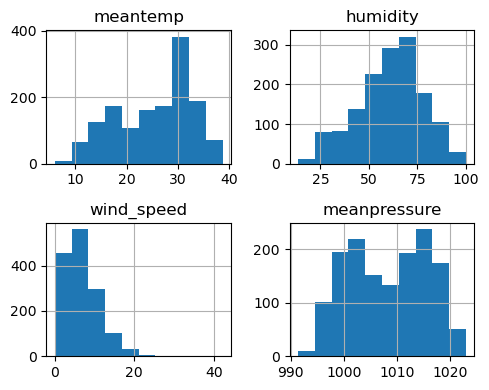

In [6]:
# Graficar histogramas
train_data.hist(figsize=(5, 4))
plt.tight_layout()
plt.show()


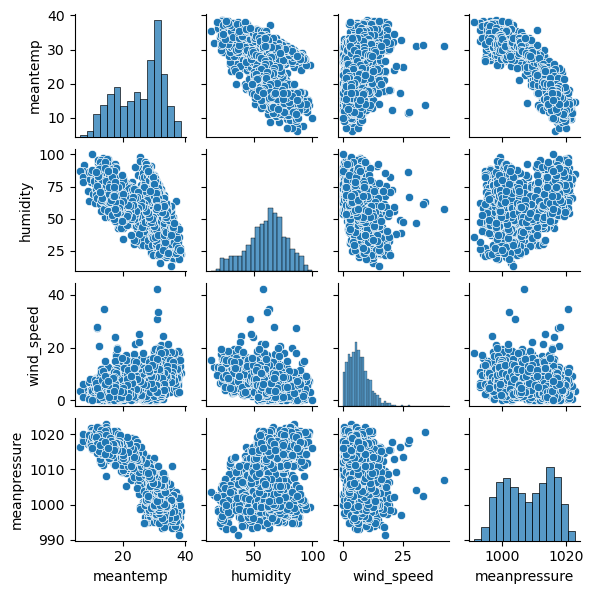

In [7]:
# Ver gráfica de pares
sns.pairplot(train_data,  height=1.5)
plt.show()


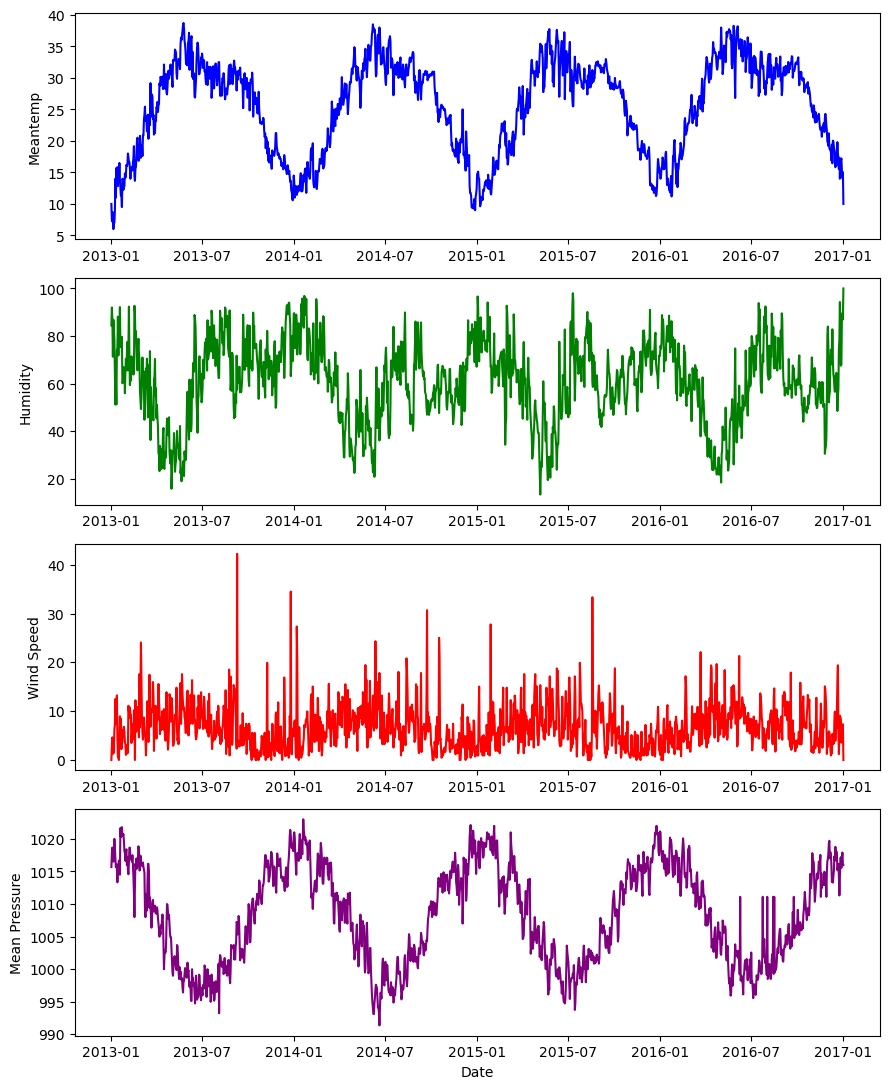

In [8]:
# Visualizar series de tiempo

# Ajustar formato fecha
train_data['date'] = pd.to_datetime(train_data['date'])

# Crear subplots
fig, axes = plt.subplots(4, 1, figsize=(9, 11), sharex=False)

# Graficar cada variable contra fecha
axes[0].plot(train_data['date'], train_data['meantemp'], color='blue')
axes[0].set_ylabel('Meantemp')

axes[1].plot(train_data['date'], train_data['humidity'], color='green')
axes[1].set_ylabel('Humidity')

axes[2].plot(train_data['date'], train_data['wind_speed'], color='red')
axes[2].set_ylabel('Wind Speed')

axes[3].plot(train_data['date'], train_data['meanpressure'], color='purple')
axes[3].set_ylabel('Mean Pressure')

axes[-1].set_xlabel('Date')

# Ajustar layout
plt.tight_layout()

# Enseñar gráfica
plt.show()


## Modelo Box-Jenkins

Para los propósitos de este ejercicio, usaremos la variable de "meantemp" (temperatura media) como nuestra Serie de Tiempo.



### Usar prueba estadística para verificar estacionariedad

In [9]:
# Pruebas de hipótesis para verificar existencia de raíz unitaria

# Prueba Dickey-Fuller Aumentada
adf_result = adfuller(train_data['meantemp'])
print('Estadístico de prueba:', adf_result[0])
print('p-valor:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

Estadístico de prueba: -2.0210690559206705
p-valor: 0.2774121372301612
Valores Críticos:
   1%: -3.4348647527922824
   5%: -2.863533960720434
   10%: -2.567831568508802


Como se podía inferir visualmente, la serie no es estacionaria.

### Transformación estabilizadora de la varianza

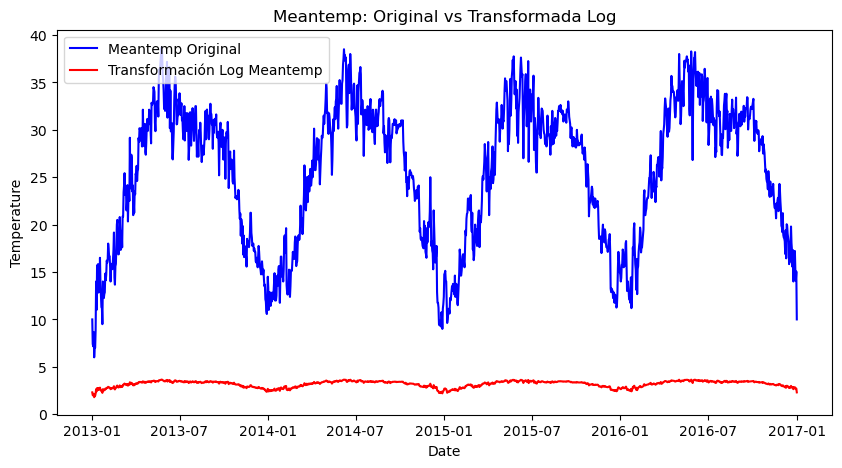

In [10]:
# Aplicamos una transformación estabilizadora de la varianza

# Apply logarithmic transformation to stabilize variance
train_data['log_meantemp'] = np.log(train_data['meantemp'])

# Plot original and transformed series
plt.figure(figsize=(10, 5))
plt.plot(train_data['date'], train_data['meantemp'], label='Meantemp Original', color='blue')
plt.plot(train_data['date'], train_data['log_meantemp'], label='Transformación Log Meantemp', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Meantemp: Original vs Transformada Log')
plt.legend()
plt.show()

In [11]:
# Aplicar prueba Dickey-Fuller Aumentada a la serie transformada
adf_result = adfuller(train_data['log_meantemp'])
print('Estadístico de prueba:', adf_result[0])
print('p-valor:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

Estadístico de prueba: -3.586511880904395
p-valor: 0.006024189473988412
Valores Críticos:
   1%: -3.43484922137066
   5%: -2.8635271063560412
   10%: -2.5678279184465946


No existe evidencia suficiente para afirmar estacionariedad, por lo tanto:

Aplicaremos el operador diferencia.

### Uso del operador diferencia

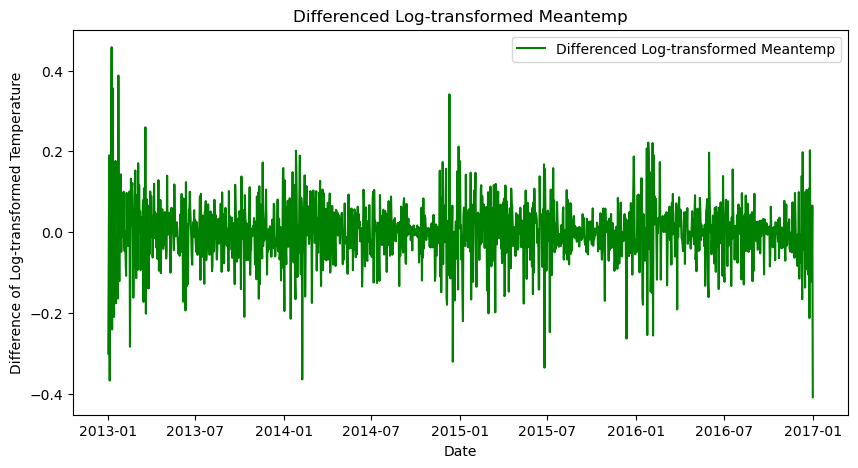

In [12]:
# Uso del operador diferencia para volver estacionaria la serie transformada

# Calculamos la primera diferencia de la serie transformada
train_data['diff_log_meantemp'] = train_data['log_meantemp'].diff()

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(train_data['date'], train_data['diff_log_meantemp'], label='Differenced Log-transformed Meantemp', color='green')
plt.xlabel('Date')
plt.ylabel('Difference of Log-transformed Temperature')
plt.title('Differenced Log-transformed Meantemp')
plt.legend()
plt.show()


In [13]:
# Como el primer valor va a ser vacío, lo sustituimos con la media

# Calcular la media
mean_value = train_data['diff_log_meantemp'].mean()

# Reemplazar valor vacío
train_data['diff_log_meantemp'].fillna(mean_value, inplace=True)


In [14]:
# Aplicar prueba Dickey-Fuller Aumentada a la serie transformada y diferenciada
adf_result = adfuller(train_data['diff_log_meantemp'])
print('Estadístico de prueba:', adf_result[0])
print('p-valor:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

Estadístico de prueba: -21.106674793391875
p-valor: 0.0
Valores Críticos:
   1%: -3.434846127900848
   5%: -2.8635257411342616
   10%: -2.5678271914441395


Debido a que:

El estadístico de prueba es -21.10,y este valor es mucho menor que los valores críticos para 1%, 5% y 10%,

y el p-valor es 0.0, lo cual indica fuerte evidencia encontra de la hipótesis nula de no estacionariedad,

se puede conlcuir que la serie de tiempo es estacionaria.



### Pruebas estadísticas para autocorrelaciones y autocorrelaciones parciales (Ljung-Box y Durbin-Watson)

In [15]:
# Aplicar prueba Ljung-Box para autocorrelaciones
lb_results = acorr_ljungbox(train_data["diff_log_meantemp"], lags=20)

# Extraer estadísticos de prueba y p-valores
lb_test_statistics = lb_results["lb_stat"]
lb_p_values = lb_results["lb_pvalue"]

In [16]:
# Comparación estadísticos de prueba con valores críticos
alpha = 0.5
for lag, lb_stat in enumerate(lb_test_statistics, start=1):
    crit_val = chi2.ppf(1 - alpha, lag)
    print(f'Lag {lag}: Estadístico de prueba Ljung-Box = {lb_stat}, Valor Crítico = {crit_val}')
    if lb_stat > crit_val:
        print(f'Lag {lag} es significativamente distinto de 0 con una significacia de 95%.')

Lag 1: Estadístico de prueba Ljung-Box = 42.79445169311687, Valor Crítico = 0.454936423119572
Lag 1 es significativamente distinto de 0 con una significacia de 95%.
Lag 2: Estadístico de prueba Ljung-Box = 45.09585369049438, Valor Crítico = 1.386294361119891
Lag 2 es significativamente distinto de 0 con una significacia de 95%.
Lag 3: Estadístico de prueba Ljung-Box = 56.705199208922345, Valor Crítico = 2.3659738843753377
Lag 3 es significativamente distinto de 0 con una significacia de 95%.
Lag 4: Estadístico de prueba Ljung-Box = 56.705206743194225, Valor Crítico = 3.3566939800333224
Lag 4 es significativamente distinto de 0 con una significacia de 95%.
Lag 5: Estadístico de prueba Ljung-Box = 58.47825084543063, Valor Crítico = 4.351460191095526
Lag 5 es significativamente distinto de 0 con una significacia de 95%.
Lag 6: Estadístico de prueba Ljung-Box = 58.53547696526848, Valor Crítico = 5.348120627447118
Lag 6 es significativamente distinto de 0 con una significacia de 95%.
Lag 7:

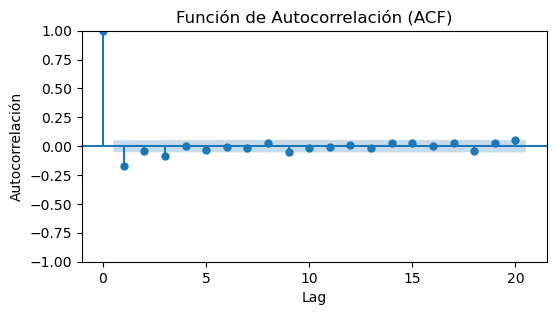

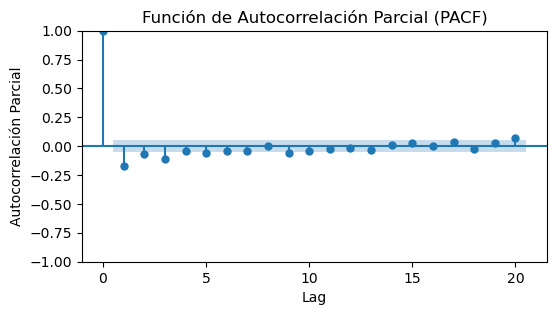

In [17]:

# Graficar ACF
plt.figure(figsize=(6, 3))
plot_acf(train_data["diff_log_meantemp"], lags=20, ax=plt.gca())
plt.title('Función de Autocorrelación (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.show()

# Graficar PACF
plt.figure(figsize=(6, 3))
plot_pacf(train_data["diff_log_meantemp"], lags=20, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación Parcial')
plt.show()


### Proponer 3 modelos de Box-Jenkins

Basado en las funciones de autocorrelación y de autocorrelación parcial, los 3 modelos propuestos son:

1. ARIMA(1,1,0)
2. ARIMA(0,1,1)
3. ARIMA(1,1,1)

## Estimación de los parámetros

In [18]:
model_1 = sm.tsa.ARIMA(train_data["meantemp"], order =(1,1,0))
model_2 = sm.tsa.ARIMA(train_data["meantemp"], order =(0,1,1))
model_3 = sm.tsa.ARIMA(train_data["meantemp"], order =(1,1,1))

results_1 = model_1.fit()
results_2 = model_2.fit()
results_3 = model_3.fit()

print(results_1.summary())
print(results_2.summary())
print(results_3.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2804.034
Date:                Tue, 30 Apr 2024   AIC                           5612.068
Time:                        23:09:46   BIC                           5622.642
Sample:                             0   HQIC                          5616.013
                               - 1462                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1610      0.020     -7.941      0.000      -0.201      -0.121
sigma2         2.7200      0.074     36.715      0.000       2.575       2.865
Ljung-Box (L1) (Q):                   0.38   Jarque-

## Verificación de los supuestos y selección del modelo

Media de los residuales: 0.007396483553379821


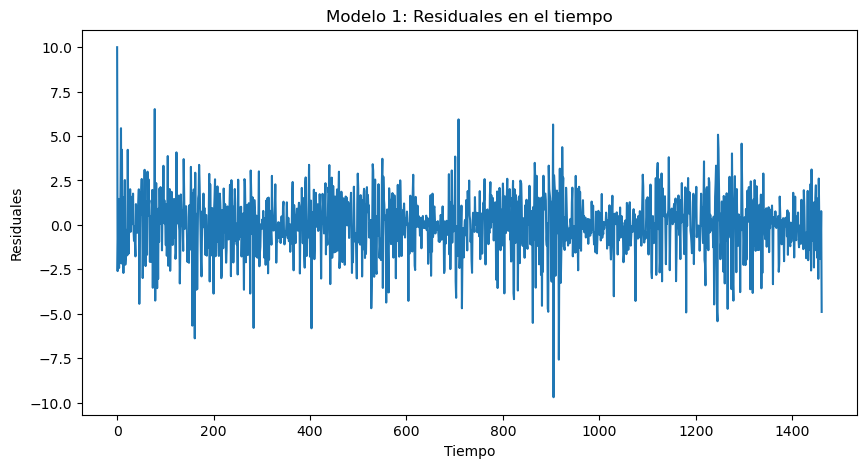

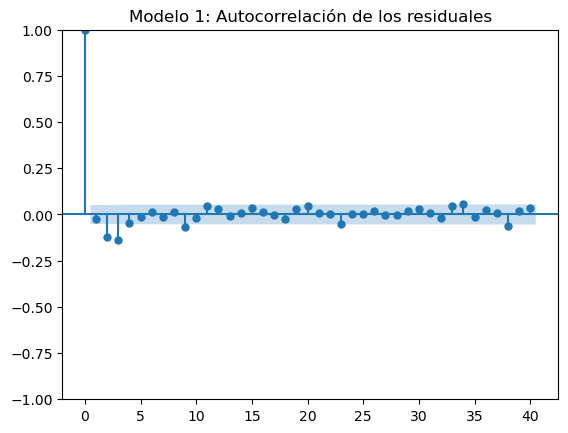

Shapiro-Wilk p-valor: 3.0954594593677384e-15


In [19]:
# Modelo 1 : ARIMA (1, 1, 0)

# 1. Residuales con media 0
mean_residuals = results_1.resid.mean()
print("Media de los residuales:", mean_residuals)

# 2. Residuales con varianza constante
plt.figure(figsize=(10, 5))
plt.plot(results_1.resid)
plt.title('Modelo 1: Residuales en el tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Residuales')
plt.show()

# 3. Independencia de los errores
# Graficar ACF de los residuales
sm.graphics.tsa.plot_acf(results_1.resid, lags=40)
plt.title("Modelo 1: Autocorrelación de los residuales")
plt.show()

# 4. Verificar normalidad de los residuales
# Prueba Shapiro-Wilk de normalidad
shapiro_test = shapiro(results_1.resid)
print("Shapiro-Wilk p-valor:", shapiro_test[1])

# 5. Identificación de valores atípicos (inspeccionar gráfico)

# 6. Modelo de Parsimonia

# 7. Admisibilidad del Modelo

# 8. Estabilidad en los parámetros


Media de los residuales: 0.007808126238003253


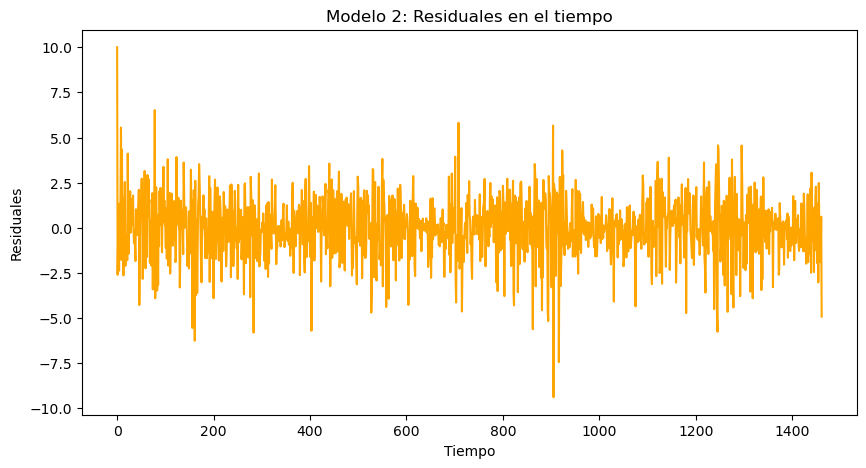

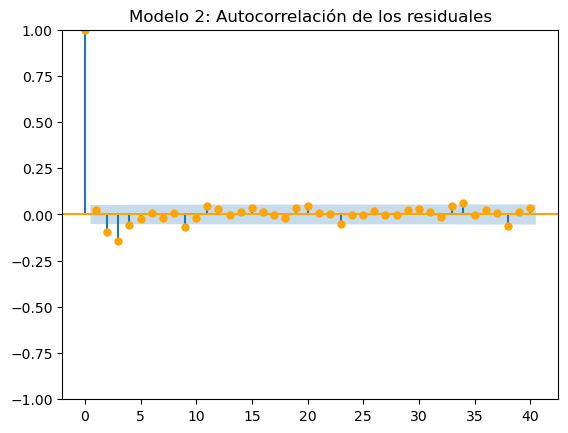

Shapiro-Wilk p-valor: 7.421846679443213e-15


In [20]:
# Modelo 2 : ARIMA (0, 1, 1)

# 1. Residuales con media 0
mean_residuals = results_2.resid.mean()
print("Media de los residuales:", mean_residuals)

# 2. Residuales con varianza constante
plt.figure(figsize=(10, 5))
plt.plot(results_2.resid, color = "orange")
plt.title('Modelo 2: Residuales en el tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Residuales')
plt.show()

# 3. Independencia de los errores
# Graficar ACF de los residuales
sm.graphics.tsa.plot_acf(results_2.resid, lags=40, color = "orange")
plt.title("Modelo 2: Autocorrelación de los residuales")
plt.show()

# 4. Verificar normalidad de los residuales
# Prueba Shapiro-Wilk de normalidad
shapiro_test = shapiro(results_2.resid)
print("Shapiro-Wilk p-valor:", shapiro_test[1])

# 5. Identificación de valores atípicos (inspeccionar gráfico)

# 6. Modelo de Parsimonia

# 7. Admisibilidad del Modelo

# 8. Estabilidad en los parámetros


Media de los residuales: 0.012107396767766771


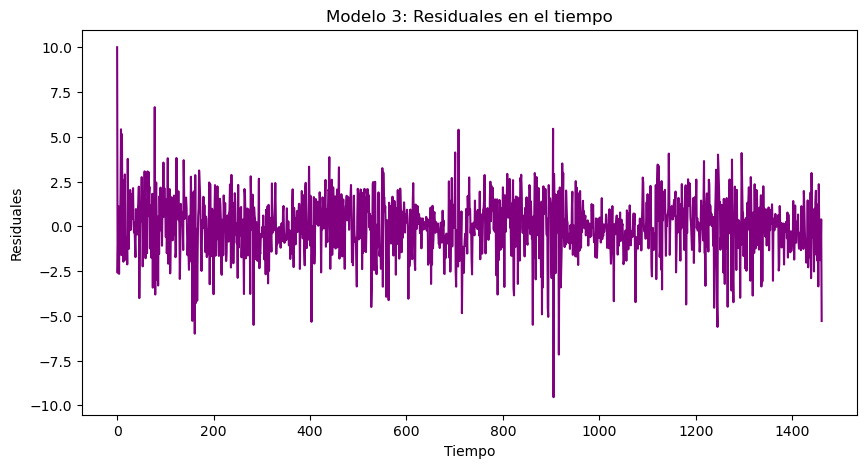

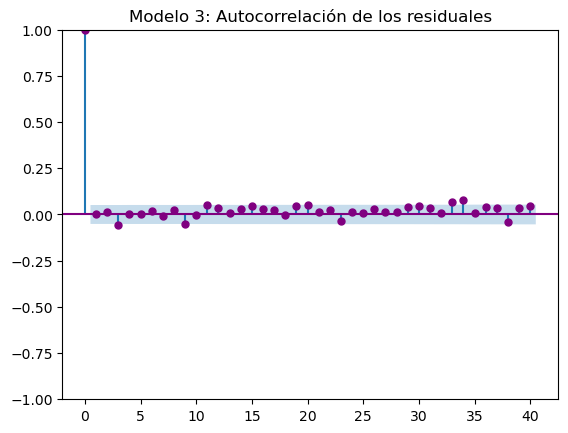

Shapiro-Wilk p-valor: 7.730849380799265e-15


In [21]:
# Modelo 3 : ARIMA (1, 1, 1)

# 1. Residuales con media 0
mean_residuals = results_3.resid.mean()
print("Media de los residuales:", mean_residuals)

# 2. Residuales con varianza constante
plt.figure(figsize=(10, 5))
plt.plot(results_3.resid, color = "purple")
plt.title('Modelo 3: Residuales en el tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Residuales')
plt.show()

# 3. Independencia de los errores
# Graficar ACF de los residuales
sm.graphics.tsa.plot_acf(results_3.resid, lags=40, color = "purple")
plt.title("Modelo 3: Autocorrelación de los residuales")
plt.show()

# 4. Verificar normalidad de los residuales
# Prueba Shapiro-Wilk de normalidad
shapiro_test = shapiro(results_3.resid)
print("Shapiro-Wilk p-valor:", shapiro_test[1])

# 5. Identificación de valores atípicos (inspeccionar gráfico)

# 6. Modelo de Parsimonia

# 7. Admisibilidad del Modelo

# 8. Estabilidad en los parámetros


Al comprobar los supuestos se selecciona el modelo ARIMA (1,1,1)

## Pronósticos e intervalos de predicción

In [22]:
# Definir orden del ARIMA
p, d, q = 1, 0, 1

# Ajustar el modelo
model = sm.tsa.ARIMA(train_data["meantemp"], order=(p, d, q))
results = model.fit()

# Predecir n pasos
n_steps = 10 
forecast = results.forecast(steps=n_steps)

# Obtener intervalos de confianza
conf_int = results.get_prediction(start=len(train_data), end=len(train_data) + n_steps - 1)
conf_int_df = conf_int.conf_int()

# Imprimir resultados
print("Predicción de valores:")
print(forecast.values)
print("\nIntervalos de confianza:")
print(conf_int_df)

Predicción de valores:
[11.24093568 11.41933995 11.59527743 11.76878221 11.93988795 12.10862781
 12.27503449 12.43914028 12.60097697 12.76057595]

Intervalos de confianza:
      lower meantemp  upper meantemp
1462        8.031483       14.450388
1463        7.348166       15.490514
1464        6.833342       16.357213
1465        6.419948       17.117617
1466        6.076350       17.803426
1467        5.784577       18.432679
1468        5.533222       19.016847
1469        5.314496       19.563784
1470        5.122790       20.079164
1471        4.953898       20.567254


### Comparación de resultados: Pronósticos vs valores reales

In [23]:
# Obtener los valores reales de los 10 pasos que pronosticamos
test_data = pd.read_csv('DailyDelhiClimateTest.csv')
valores_reales = test_data.loc[:9, "meantemp"]
print("Valores reales")
print(valores_reales)


Valores reales
0    15.913043
1    18.500000
2    17.111111
3    18.700000
4    18.388889
5    19.318182
6    14.708333
7    15.684211
8    14.571429
9    12.111111
Name: meantemp, dtype: float64


In [24]:
# Convertir listas a numpy arrays
forecast = np.array(forecast)
valores_reales = np.array(valores_reales)

In [25]:
# Comparar valores
comparacion = pd.DataFrame({'Valores reales': valores_reales, 'Valores pronosticados': forecast})
comparacion

,Valores reales,Valores pronosticados
0,15.913043,11.240936
1,18.500000,11.419340
2,17.111111,11.595277
3,18.700000,11.768782
4,18.388889,11.939888
5,19.318182,12.108628
6,14.708333,12.275034
7,15.684211,12.439140
8,14.571429,12.600977
9,12.111111,12.760576


In [26]:
# Calcular métricas
mae = np.mean(np.abs(forecast - valores_reales))
mse = np.mean((forecast - valores_reales) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((valores_reales - forecast) / valores_reales)) * 100

# Imprimir métricas de evaluación
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error (MAE): 4.615665978457772
Mean Squared Error (MSE): 26.4753729559444
Root Mean Squared Error (RMSE): 5.145422524530361
Mean Absolute Percentage Error (MAPE): 26.544392655725048
